# Crime prediction using statistical learning and urban metrics

* Data description: metric distributions are non-gaussians;
* Co-linearity: correlations between metrics;
* Regression model;
* Machine learning approach;
- Underfitting and Overfitting;
- Prediction vs. data;



# Libraries and settings

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Standard Library
import os
import time
import math
import subprocess
import random

# Third Party Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib import ticker
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.stats.multitest as smm            
from matplotlib import gridspec

In [15]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7.*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                    "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
              'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15
              }
    mpl.rcParams.update(rcparams) 

stdrcparams(usetex=True)
figsize=stdfigsize()

/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


## Functions

In [5]:
def winm(x, y, nw):
    xw = []
    yw = []
    step = (max(x) - min(x)) / nw
    lw = [min(x) + step * i for i in range(0, nw)]
    for i in range(0, len(lw) - 1):
        if len(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]) > 0:
            xw.append(np.mean(x[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
            yw.append(np.mean(y[x > lw[i]][x[x > lw[i]] < lw[i + 1]]))
    return (np.array(xw), np.array(yw))

def f(x,a,b):
    return a*x+b

def box_plot_style(ax,bp,ymin=0,ymax=1,ylabel='y',xticklabels=None,fontsize=20):
    ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='black', linewidth=1)
        # change fill color
        box.set( facecolor='#bdbdbd',zorder=3)

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='black', linewidth=1,zorder=4)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='k', linewidth=1,zorder=4)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', markerfacecolor='k',
                  markeredgecolor='k',markersize=4,zorder=3)

    ## Remove top axes and right axes ticks
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(' ',ha='center')
    ax.set_ylabel(ylabel)
    if xticklabels is not None:
        ax.set_xticklabels(xticklabels,rotation=45, ha='right',fontsize=fontsize)

def test2samples(data_to_plot):
    data_to_plot=data_to_plot.T
    m,n=data_to_plot.shape
    indexes=[]
    new_p=[]
    for j in range(0,m):
        for i in range(0,m):
            s1=[x for x in data_to_plot[j] if str(x) != 'nan']
            s2=[x for x in data_to_plot[i] if str(x) != 'nan']
            tstat, pvalue=stats.ttest_ind(s1,s2, equal_var = False)
            #ustat, pvalue=stats.mannwhitneyu(s1,s2)
            if i <j:
                new_p.append(pvalue)
                indexes.append((i, j))

    # Plot p-values with correction for multiple testing    
    a, corrected_p, c, d = smm.multipletests(new_p, method='b')
    p_array = np.ones((m, m))
    for (i, j), pv in zip(indexes, corrected_p):
        p_array[i, j] = p_array[j, i] =  round(pv, ndigits=3)
    return p_array

def model_scores(prediction,testY):
    df=pd.DataFrame(columns=["Metric","Score"])
    df.loc[0]=["R-square", metrics.r2_score(testY,prediction)]
    df.loc[1]=["Explained variance", metrics.explained_variance_score(testY,prediction)]
    df.loc[2]=["Mean absolute error", metrics.mean_absolute_error(testY,prediction)]
    df.loc[3]=["Mean squared error", metrics.mean_squared_error(testY,prediction)]
    df.loc[4]=["Median absolute error", metrics.median_absolute_error(testY,prediction)]  
    return df

# Load data

In [6]:
indicators=['Population',
       'Homicides', 'Suicides', 'Traffic accidents',
       'Elderly population', 'Female population ', 'Male population','GDP',
       'Income', 'Unemployment', 'Illiteracy', 'Sanitation', 'Child Labor']

In [10]:
datasets=dict()
for year in [2000,2010]:
    datasets[year]=pd.read_csv(f'data/data-{year}.csv',index_col=0)

In [12]:
datasets[2000].head()

,Population,Homicides,Suicides,Traffic accidents,Elderly population,Female population,Male population,GDP,Income,Unemployment,Illiteracy,Sanitation,Child Labor,CityUF
0,26533,3,2,5,1486,12609,13924,98023.0,371.48,704,2510,25951,1133,"ALTA FLORESTA D'OESTE, RO"
1,74503,46,6,17,3498,36508,37995,381793.4,527.92,2869,5232,71874,1584,"ARIQUEMES, RO"
2,7518,0,0,1,555,3556,3962,33496.4,344.05,173,841,7488,218,"CABIXI, RO"
3,73568,13,10,13,4312,36350,37218,385936.5,452.34,2760,5672,73271,1874,"CACOAL, RO"
4,18207,2,0,3,1294,8890,9317,89764.6,509.20,841,1503,18135,464,"CEREJEIRAS, RO"


Text(0, 0.5, 'Homicides')

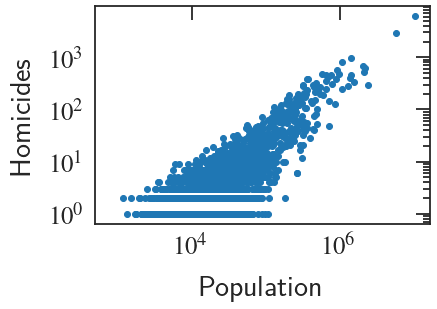

In [163]:
plt.loglog(datasets[2000].Population,datasets[2000].Homicides,'o')
plt.xlabel('Population')
plt.ylabel('Homicides')

# Correlation

/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


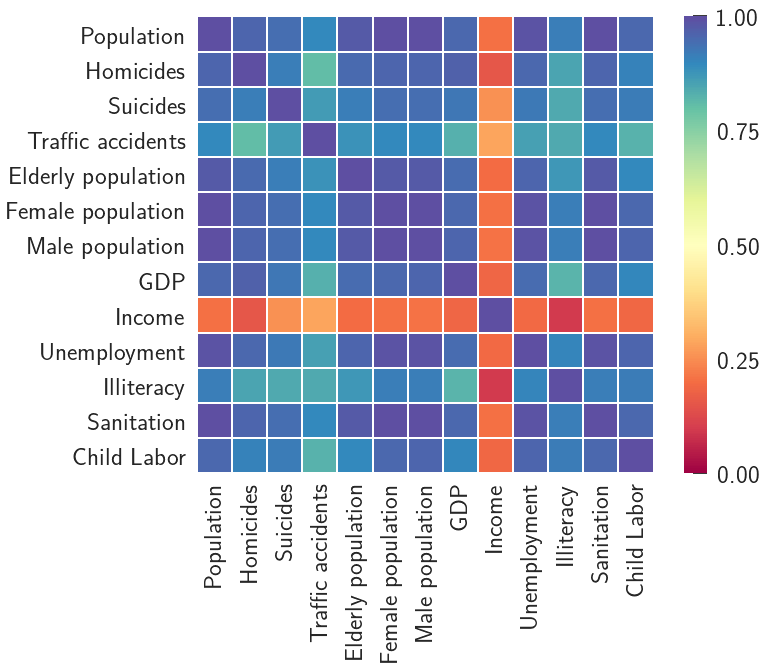

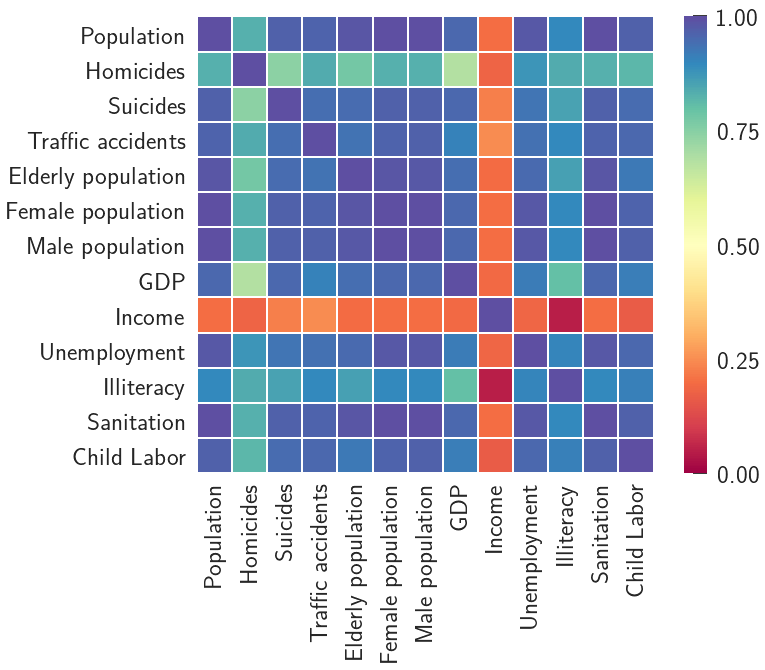

In [13]:
for year in [2000,2010]:
    correlation=np.zeros((len(indicators),len(indicators)))
    for i in range(0,len(indicators)):
        for j in range(0,len(indicators)):
            x=np.nan_to_num(datasets[year][indicators[i]])
            y=np.nan_to_num(datasets[year][indicators[j]])
            r,pvalue=stats.pearsonr(x,y)
            correlation[i][j]=r
    df_corr=pd.DataFrame(correlation,columns=indicators,index=indicators)     
    
    fig, ax = plt.subplots(figsize=stdfigsize(scale=1.2))
    res=sns.heatmap(df_corr,vmin=0 ,vmax=1.,linewidth=1,cmap="Spectral",square=True)
    #ax.set_title("Year={}".format(year))
    cbar = res.collections[0].colorbar
    cbar.set_ticks([0., 0.25,0.5, 0.75, 1])
    cbar.set_ticklabels(['0.00', '0.25',"0.50", '0.75', '1.00'])

# Regression models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Data splitting

In [122]:
df_dataset=datasets[2000][np.concatenate([indicators,["CityUF"]])]
df_dataset["Y"]=np.array(datasets[2010]["Homicides"])
df_dataset=df_dataset[df_dataset.Population>0]
df_dataset=df_dataset.dropna()

df_dataset=datasets[2000][indicators]
df_dataset["Y"]=np.array(datasets[2010]["Homicides"])
df_dataset=df_dataset[df_dataset.Population>0]

df_dataset=df_dataset.dropna()
X=np.array(df_dataset[indicators])
Y=np.array(df_dataset["Y"])
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.)

In [19]:
df_dataset.head()

,Population,Homicides,Suicides,Traffic accidents,Elderly population,Female population,Male population,GDP,Income,Unemployment,Illiteracy,Sanitation,Child Labor,Y
0,26533,3,2,5,1486,12609,13924,98023.0,371.48,704,2510,25951,1133,7
1,74503,46,6,17,3498,36508,37995,381793.4,527.92,2869,5232,71874,1584,43
2,7518,0,0,1,555,3556,3962,33496.4,344.05,173,841,7488,218,0
3,73568,13,10,13,4312,36350,37218,385936.5,452.34,2760,5672,73271,1874,20
4,18207,2,0,3,1294,8890,9317,89764.6,509.20,841,1503,18135,464,9


## Linear regression

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.me

### Prediction

In [22]:
lm = LinearRegression(normalize=True)

In [29]:
prediction=[]
for i in range(0,100):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
    prediction.append([])
    lm.fit(trainX,trainY)
    prediction_lm=lm.predict(testX)
    prediction[i]=prediction_lm.astype(int)

In [30]:
prediction_lm= prediction[10]

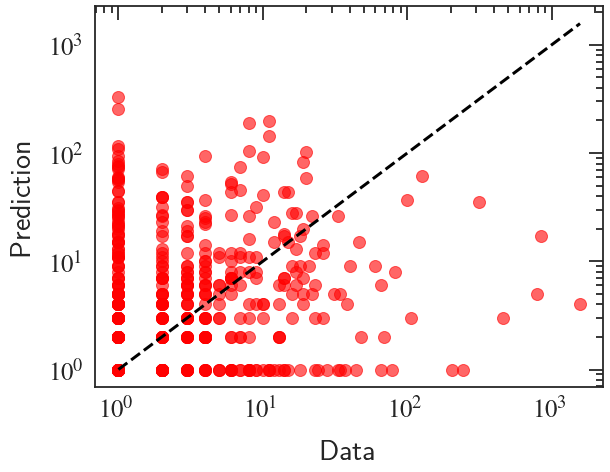

In [31]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel("Data")
ax.set_ylabel("Prediction")
ax.plot(testY,prediction_lm,"o",markersize=12,color="red",alpha=0.6)
ax.plot(np.arange(1,max(testY),0.1),np.arange(1,max(testY),0.1),"k--",linewidth=3)
#ax.legend(fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')

In [32]:
x=(np.array(prediction_lm)-np.array(testY))
stats.kstest(x,'norm')

KstestResult(statistic=0.36200485897741064, pvalue=7.04762181832909e-130)

Text(0.5, 0, 'Normal quantiles')

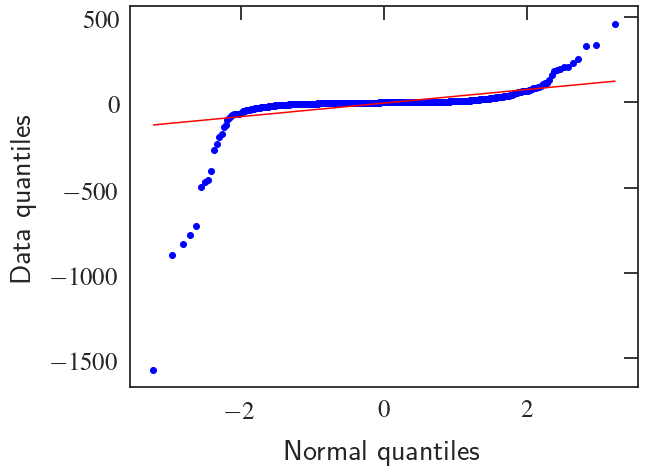

In [33]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
x=(np.array(prediction_lm)-np.array(testY))
res = stats.probplot(x, dist=stats.norm, plot=ax)
ax.set_title('')
ax.set_ylabel("Data quantiles")
ax.set_xlabel("Normal quantiles")

In [34]:
prediction=[]
accuracy=[]
for i in range(0,1000):
    prediction.append([])
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
    lm.fit(trainX,trainY)
    prediction_lm=lm.predict(testX)
    accuracy.append(metrics.r2_score(testY,prediction_lm))

0.7549262202184088 0.15764615395949527


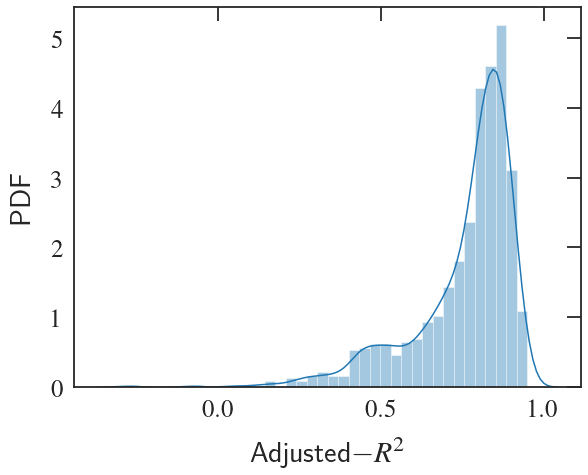

In [35]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel("PDF")
ax.set_xlabel("Adjusted$-R^2$")
sns.distplot(accuracy,kde=True)
#ax.set_yscale("log")
print(np.mean(accuracy),np.std(accuracy))

### Feature importance

In [52]:
importance_df_lm=pd.DataFrame()
importance_df_lm["Feature"]=indicators
for i in range(0,100):
    df=df_dataset.sample(frac=1,replace=True)
    X=np.array(df[indicators])
    Y=np.array(df["Y"])
    lm.fit(X,Y)
    importance_df_lm[i]=lm.coef_

In [53]:
importance_df_lm.head()

,Feature,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,Population,0.003433,0.001205,0.001659,0.003735,0.002916,0.000495,0.000621,0.004190,0.002260,...,0.001934,0.001173,0.000632,0.002291,0.001555,0.002625,0.002546,0.003368,0.002198,0.001237
1,Homicides,-0.296301,-0.296986,-0.285744,-0.207770,-0.221917,-0.107107,0.089143,-0.138719,-0.115571,...,-0.303483,-0.201105,-0.146938,-0.145022,-0.071291,-0.421707,-0.129343,-0.008964,-0.214746,-0.151525
2,Suicides,-0.990634,-1.633985,-1.751442,-0.876494,-1.976891,-1.156921,-1.380040,-0.398277,-2.004530,...,-2.045403,-2.336204,-1.532211,-0.893832,-1.019878,-1.136724,-0.587082,-1.574812,-3.422511,-1.626796
3,Traffic accidents,1.197237,0.781002,1.090773,1.032370,1.081396,0.988405,0.529056,0.547046,0.653225,...,0.860859,0.998039,0.823998,1.281072,0.896525,1.359115,0.644850,1.258148,1.026815,1.249700
4,Elderly population,-0.003297,-0.002610,-0.002665,-0.003567,-0.002863,-0.006827,-0.004068,-0.005340,-0.004767,...,-0.003216,-0.002267,-0.005167,-0.004169,-0.004141,-0.002949,-0.006443,-0.002934,-0.002590,-0.004539


In [54]:
importance_df_lm=importance_df_lm.set_index("Feature").T
features=list(importance_df_lm.columns)
medians=[]
for feature in features:
    m=np.median(importance_df_lm[feature])
    medians.append(m)

importance_df_lm=importance_df_lm.T
importance_df_lm["Medians"]=medians

importance_df_lm.sort_values(by="Medians",inplace=True,ascending=False)
del importance_df_lm['Medians']

importance_df_lm=importance_df_lm.T

[Text(0, 0, 'Traffic accidents'),
 Text(0, 0, 'Female population '),
 Text(0, 0, 'Unemployment'),
 Text(0, 0, 'Population'),
 Text(0, 0, 'Illiteracy'),
 Text(0, 0, 'Male population'),
 Text(0, 0, 'GDP'),
 Text(0, 0, 'Income'),
 Text(0, 0, 'Elderly population'),
 Text(0, 0, 'Sanitation'),
 Text(0, 0, 'Child Labor'),
 Text(0, 0, 'Homicides'),
 Text(0, 0, 'Suicides')]

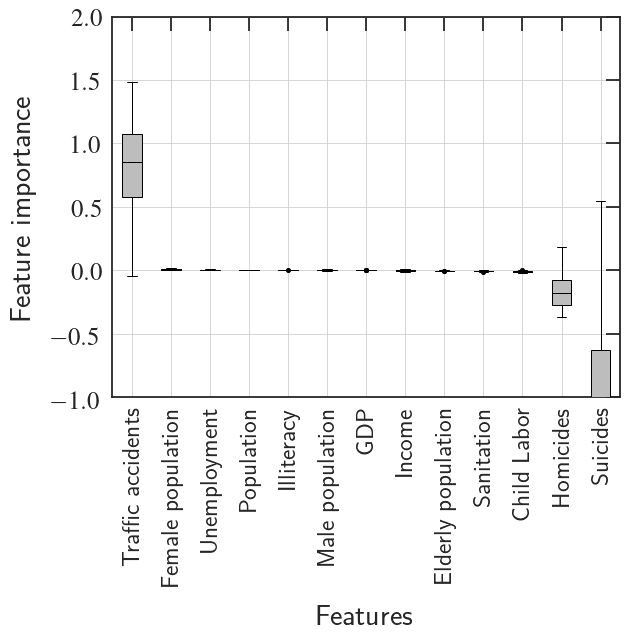

In [50]:
# Create a figure instance
fig = plt.figure(1, figsize=figsize)
ax = fig.add_subplot(111)
ax.grid()
bp = ax.boxplot(np.array(importance_df_lm), patch_artist=True,showfliers=True)
## change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=1)
    # change fill color
    box.set( facecolor='#bdbdbd',zorder=3)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='black', linewidth=1,zorder=4)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=1,zorder=4)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', markerfacecolor='k',
              markeredgecolor='k',markersize=4,zorder=3)
ax.set_xlabel('Features')
ax.set_ylabel('Feature importance')
#ax.set_yscale('log')
ax.set_ylim(-1,2)
ax.set_xticklabels(labels=list(importance_df_lm.columns),rotation=90)
#plt.savefig("../figures/features_importance.pdf",bbox_inches='tight')    

/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


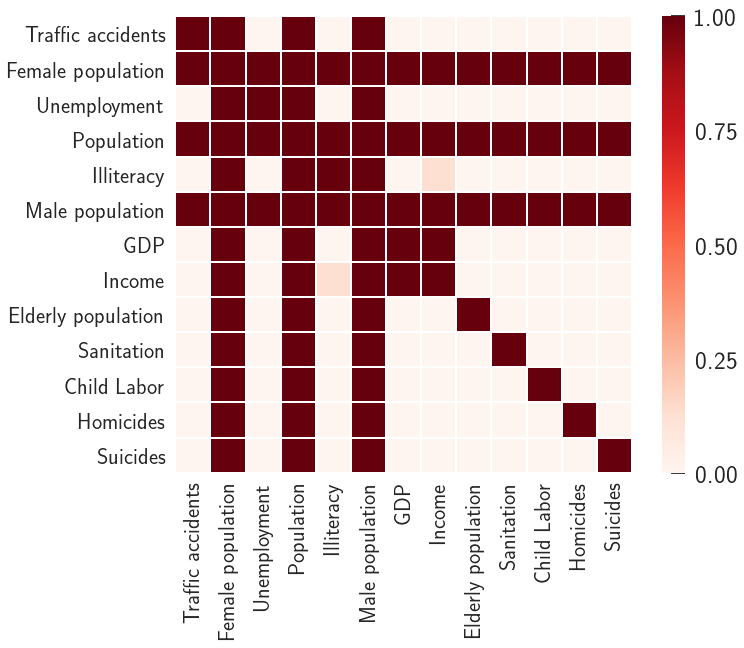

In [51]:
p=test2samples(np.array(importance_df_lm))
p=pd.DataFrame(p,index=list(importance_df_lm.columns),columns=list(importance_df_lm.columns))
fig, ax = plt.subplots(figsize=stdfigsize(scale=1.2))
res=sns.heatmap(p,vmin=0,vmax=1.,linewidths=1,annot=False,cmap="Reds",square=True)
cbar = res.collections[0].colorbar
cbar.set_ticks([0,0.25, 0.5,0.75, 1])
cbar.set_ticklabels(["0.00","0.25", "0.50","0.75", "1.00"])
ax.tick_params(labelsize=22)

## Random Forest

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

In [57]:
df_dataset=datasets[2000][np.concatenate([indicators,["CityUF"]])]
df_dataset["Y"]=np.array(datasets[2010]["Homicides"])
df_dataset=df_dataset[df_dataset.Population>0]
df_dataset=df_dataset.dropna()

df_dataset=datasets[2000][indicators]
df_dataset["Y"]=np.array(datasets[2010]["Homicides"])
df_dataset=df_dataset[df_dataset.Population>0]

df_dataset=df_dataset.dropna()
X=np.array(df_dataset[indicators])
Y=np.array(df_dataset["Y"])
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.)

### Random Forest algorithm

In [58]:
rf=RandomForestRegressor(n_estimators=200,
                    criterion='mse', 
                    max_depth=50, 
                    min_samples_split=2, 
                    min_samples_leaf=1, 
                    min_weight_fraction_leaf=0.0, 
                    max_features='auto', 
                    max_leaf_nodes=None, 
                    min_impurity_split=1e-07, 
                    bootstrap=True, 
                    oob_score=False, 
                    n_jobs=-1, 
                    random_state=None, 
                    verbose=0,
                    warm_start=False)

### Underfitting and Overfitting

In statistics and machine learning, the bias–variance tradeoff (or dilemma) is the problem of simultaneously minimizing two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:

**Underfitting**: The bias is error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).

**Overfitting**: The variance is error from sensitivity to small fluctuations in the training set. High variance can cause overfitting: modeling the random noise in the training data, rather than the intended outputs.


Finding an $\hat {f}$ that generalizes to points outside of the training set can be done with any of the countless algorithms used for supervised learning. It turns out that whichever function $\hat {f}$ we select, we can decompose its expected error on an unseen sample $x$ as follows*

\begin{aligned}{\mathrm  {E}}{\Big [}{\big (}y-{\hat  {f}}(x){\big )}^{2}{\Big ]}&={\mathrm  {Bias}}{\big [}{\hat  {f}}(x){\big ]}^{2}+{\mathrm  {Var}}{\big [}{\hat  {f}}(x){\big ]}+\sigma ^{2}\\\end{aligned}
Where:

\begin{aligned}\mathrm {Bias} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} {\big [}{\hat {f}}(x)-f(x){\big ]}\end{aligned}

and

\begin{aligned}\mathrm {Var} {\big [}{\hat {f}}(x){\big ]}=\mathrm {E} [{\hat {f}}(x)^{2}]-\mathrm {E} [{\hat {f}}(x)]^{2}\end{aligned}


* Gareth James; Daniela Witten; Trevor Hastie; Robert Tibshirani (2013). An Introduction to Statistical Learning. Springer.


### Validation curve

#### Number of trees

In [67]:
X, y = trainX,trainY
param_range =np.logspace(0,3,10).astype(int)
train_scores, test_scores = validation_curve(RandomForestRegressor().set_params(**{'bootstrap': True,
                                                           'max_depth': 50,
                                                           'max_features': 'auto',
                                                           'min_samples_split': 2}), 
                                             X, y, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             cv=10, 
                                             scoring=None, 
                                             n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [66]:
np.logspace(0,3,10).astype(int)

array([   1,    2,    4,   10,   21,   46,  100,  215,  464, 1000])

In this plot you can see the training scores and validation scores of a Random Forest Regressor for different values of the parameter n_estimators (Number of trees). For very low values of n_estimators, you can see that both the training score and the validation score are slightly lower. This is called underfitting. Medium values of n_estimators will result in high values for both scores, i.e. the regressor is performing fairly well. If n_estimators is too high, the regressors will overfit, which means that the training score is good but the validation score is poor. We do not see this here because up to 10000 trees the model is still performing well.

See more at: 
* http://scikit-learn.org/stable/modules/learning_curve.html
* http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html


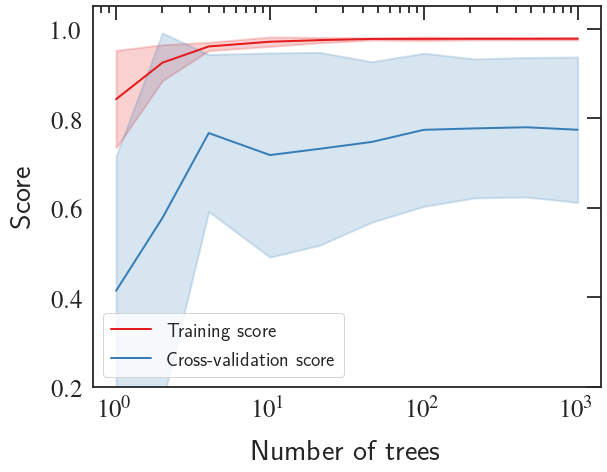

In [68]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Number of trees")
ax.set_ylabel("Score")
ax.set_ylim(0.2,1.05)
lw = 2
#ax.grid()
ax.plot(param_range, train_scores_mean, label="Training score",
             color="#e41a1c", lw=lw)
ax.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="#e41a1c", lw=lw)
ax.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="#377eb8", lw=lw)
ax.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="#377eb8", lw=lw)
ax.set_xscale("log")
ax.legend(loc="lower left",fontsize=20)

#### Maximal depth

In [75]:
X, y = trainX,trainY
param_range_max_depth =np.logspace(0.1,2,10).astype(int)
train_scores, test_scores = validation_curve(RandomForestRegressor(n_estimators=100), 
                                             X, y, 
                                             param_name="max_depth", 
                                             param_range=param_range_max_depth,
                                             cv=10, 
                                             scoring=None, 
                                             n_jobs=-1)

train_scores_mean_max_depth = np.mean(train_scores, axis=1)
train_scores_std_max_depth = np.std(train_scores, axis=1)
test_scores_mean_max_depth = np.mean(test_scores, axis=1)
test_scores_std_max_depth = np.std(test_scores, axis=1)

In [76]:
param_range_max_depth

array([  1,   2,   3,   5,   8,  14,  23,  37,  61, 100])

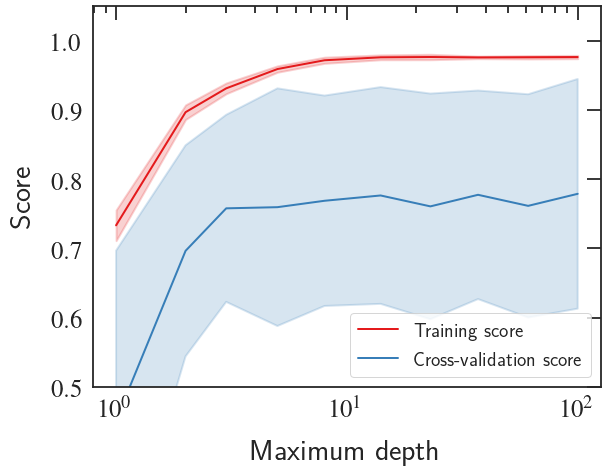

In [77]:
fig, ax = plt.subplots(figsize=figsize)

ax.set_xlabel("Maximum depth")
ax.set_ylabel("Score")
ax.set_ylim(0.5,1.05)
lw = 2
ax.plot(param_range_max_depth, train_scores_mean_max_depth, label="Training score",
             color="#e41a1c", lw=lw)
ax.fill_between(param_range_max_depth, train_scores_mean_max_depth - train_scores_std_max_depth,
                 train_scores_mean_max_depth + train_scores_std_max_depth, alpha=0.2,
                 color="#e41a1c", lw=lw)
ax.plot(param_range_max_depth, test_scores_mean_max_depth, label="Cross-validation score",
             color="#377eb8", lw=lw)
ax.fill_between(param_range_max_depth, test_scores_mean_max_depth - test_scores_std_max_depth,
                 test_scores_mean_max_depth + test_scores_std_max_depth, alpha=0.2,
                 color="#377eb8", lw=lw)
ax.set_xscale("log")
ax.legend(loc="lower right",fontsize=20)

### Learning curves

In [113]:
X, y = trainX,trainY
estimator = RandomForestRegressor(n_jobs=-1).set_params(**{'bootstrap': True,
                                                           'max_depth': 50,
                                                           'max_features': 'auto',
                                                           'min_samples_split': 2,
                                                           'n_estimators': 100})
train_sizes_lc=np.linspace(.1, 1.0, 10)

train_sizes_lc, train_scores, test_scores = learning_curve(estimator, 
                                                        X, 
                                                        y, 
                                                        cv=10, 
                                                        n_jobs=-1, 
                                                        train_sizes=train_sizes_lc)
train_scores_mean_lc = np.mean(train_scores, axis=1)
train_scores_std_lc = np.std(train_scores, axis=1)
test_scores_mean_lc = np.mean(test_scores, axis=1)
test_scores_std_lc = np.std(test_scores, axis=1)

The shape of the curve for the training score is very high at the beginning and decreases and the cross-validation score is very low at the beginning and increases. However, we can see a maximum around 2500, showning that, actually, given more data is not making it better. 

See more at:
http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

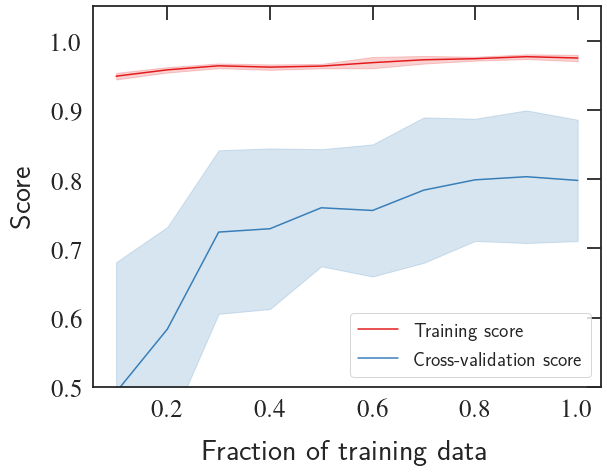

In [114]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel("Fraction of training data")
ax.set_ylabel("Score")
ax.set_ylim(0.5,1.05)
#ax.grid()
ax.fill_between(np.linspace(.1, 1.0, 10), train_scores_mean_lc - train_scores_std_lc,
                 train_scores_mean_lc + train_scores_std_lc, alpha=0.2,
                 color="#e41a1c")
ax.fill_between(np.linspace(.1, 1.0, 10), test_scores_mean_lc - test_scores_std_lc,
                 test_scores_mean_lc + test_scores_std_lc, alpha=0.2, color="#377eb8")
ax.plot(np.linspace(.1, 1.0, 10), train_scores_mean_lc, '-', color="#e41a1c",
         label="Training score")
ax.plot(np.linspace(.1, 1.0, 10), test_scores_mean_lc, '-', color="#377eb8",
         label="Cross-validation score")
ax.legend(loc="lower right",fontsize=20)

### Tunning model

The main parameters to adjust when using these methods is n_estimators and max_features. The former is the number of trees in the forest. The larger the better, but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. The latter is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=n_features for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data). Good results are often achieved when setting max_depth=None in combination with min_samples_split=1 (i.e., when fully developing the trees). Bear in mind though that these values are usually not optimal, and might result in models that consume a lot of RAM. The best parameter values should always be cross-validated. In addition, note that in random forests, bootstrap samples are used by default (bootstrap=True) while the default strategy for extra-trees is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.

In [115]:
RandomForestRegressor?

In [116]:
def Grid_Search_CV_RFR(X_train, y_train):
    estimator = RandomForestRegressor()
    param_grid = {  "n_estimators": [100,200,500],
                    "max_depth":[10,50,100],
                    "max_features": ["auto"],
                    "min_samples_split" : [2,4,8],
                    "bootstrap": [True,False]}
    grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=10)

    grid.fit(X_train, y_train)

    return grid.best_score_ , grid.best_params_

In [ ]:
best_score_rf,best_params_rf=Grid_Search_CV_RFR(trainX, trainY)

In [117]:
best_score_rf,best_params_rf=(0.89291467777356359,
 {'bootstrap': True,
  'max_depth': 100,
  'max_features': 'auto',
  'min_samples_split': 4,
  'n_estimators': 200})

### Fitting the data and prediction

In [120]:
rf = RandomForestRegressor(n_jobs=-1).set_params(**{'bootstrap': True,
  'max_depth': 100,
  'max_features': 'auto',
  'min_samples_split': 4,
  'n_estimators': 200})

In [123]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1)

In [165]:
prediction=[]
accuracy=[]
for i in range(0,10):
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.1)
    prediction.append([])
    rf.fit(trainX,trainY)
    prediction_rf=rf.predict(testX)
    prediction[i]=prediction_rf.astype(int)
    accuracy.append(rf.score(testX,testY))

In [136]:
prediction_rf=np.median(prediction,axis=0)
prediction_rf

array([3.5, 1. , 1.5, ..., 1.5, 0. , 3. ])

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_xlabel("Data")
ax.set_ylabel("Prediction")
ax.plot(testY,prediction_rf,"o",markersize=12,color="red",alpha=0.6)
ax.plot(np.arange(1,max(testY),0.1),np.arange(1,max(testY),0.1),"k--",linewidth=3)
#ax.legend(fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')

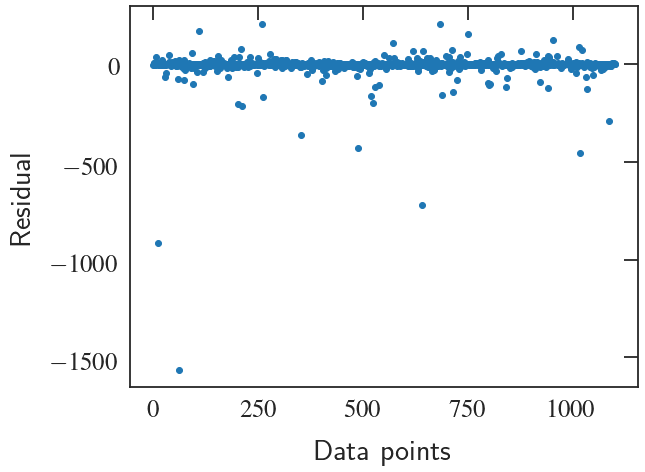

In [149]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel("Residual")
ax.set_xlabel("Data points")
ax.plot((np.array(prediction_rf)-np.array(testY)),'o')

In [ ]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel("PDF")
ax.set_xlabel("Residuals")
sns.distplot((np.array(prediction_rf)-np.array(testY)),kde=False)
print(np.mean(np.array(prediction_rf)-np.array(testY)),np.std(np.array(prediction_rf)-np.array(testY)))

In [150]:
prediction=[]
accuracy=[]
for i in range(0,10):
    prediction.append([])
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
    rf.fit(trainX,trainY)
    prediction_rf=rf.predict(testX)
    accuracy.append(metrics.r2_score(testY,prediction_rf))

0.8087712790684985 0.10440155751702972


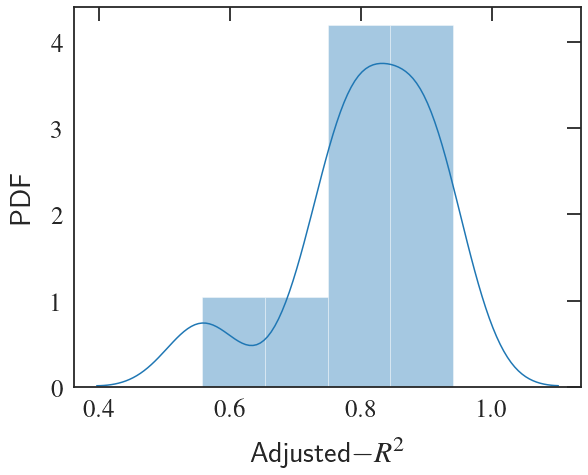

In [151]:
fig, ax = plt.subplots(figsize=figsize)
ax.set_ylabel("PDF")
ax.set_xlabel("Adjusted$-R^2$")
sns.distplot(accuracy,kde=True)
#ax.set_yscale("log")
print(np.mean(accuracy),np.std(accuracy))

In [ ]:
max(accuracy)

In [153]:
scores_df=model_scores(prediction_rf,testY)
scores_df

,Metric,Score
0,R-square,0.727775
1,Explained variance,0.728118
2,Mean absolute error,5.009861
3,Mean squared error,458.510678
4,Median absolute error,1.100125


### Features importance

In [166]:
importance_df=pd.DataFrame()
importance_df["Feature"]=indicators
for i in range(0,10):
    X=np.array(df_dataset[indicators])
    Y=np.array(df_dataset["Y"])
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
    rf.fit(trainX,trainY)
    importance_df[i]=rf.feature_importances_

In [167]:
importance_df

,Feature,0,1,2,3,4,5,6,7,8,9
0,Child Labor,0.041079,0.028574,0.061258,0.020963,0.050365,0.036671,0.041241,0.016183,0.063038,0.025254
1,Elderly population,0.051066,0.038709,0.019813,0.030695,0.017829,0.010706,0.030543,0.023897,0.022193,0.019704
2,Female population,0.138356,0.038144,0.066694,0.059373,0.062989,0.058436,0.084579,0.075867,0.081445,0.044951
3,GDP,0.016414,0.004092,0.005868,0.009894,0.007372,0.005097,0.008424,0.004955,0.006709,0.008924
4,Homicides,0.044421,0.065223,0.034927,0.043111,0.052627,0.050583,0.025946,0.023074,0.060419,0.042505
5,Illiteracy,0.188686,0.336791,0.081536,0.327792,0.249781,0.271592,0.130126,0.110609,0.152723,0.296007
6,Income,0.006040,0.009417,0.007358,0.016700,0.011846,0.014553,0.009475,0.011090,0.013474,0.009436
7,Male population,0.084958,0.073214,0.109259,0.116867,0.082133,0.100747,0.154591,0.090640,0.073342,0.097411
8,Population,0.113927,0.065636,0.117940,0.067291,0.096359,0.087083,0.114373,0.057749,0.050471,0.063423
9,Sanitation,0.090450,0.086323,0.068805,0.062347,0.054182,0.068763,0.139018,0.057552,0.053477,0.093638


In [168]:
importance_df=importance_df.set_index("Feature").T
features=list(importance_df.columns)
medians=[]
for feature in features:
    m=np.median(importance_df[feature])
    medians.append(m)

importance_df=importance_df.T
importance_df["Medians"]=medians

importance_df.sort_values(by="Medians",inplace=True,ascending=False)
del importance_df['Medians']

importance_df=importance_df.T

[Text(0, 0, 'Unemployment'),
 Text(0, 0, 'Illiteracy'),
 Text(0, 0, 'Male population'),
 Text(0, 0, 'Population'),
 Text(0, 0, 'Sanitation'),
 Text(0, 0, 'Female population '),
 Text(0, 0, 'Homicides'),
 Text(0, 0, 'Child Labor'),
 Text(0, 0, 'Traffic accidents'),
 Text(0, 0, 'Elderly population'),
 Text(0, 0, 'Suicides'),
 Text(0, 0, 'Income'),
 Text(0, 0, 'GDP')]

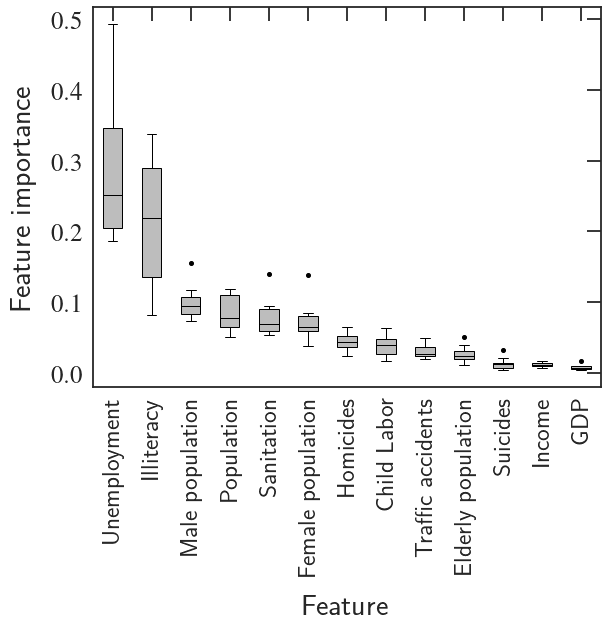

In [169]:
# Create a figure instance
fig = plt.figure(1, figsize=figsize)
ax = fig.add_subplot(111)

bp = ax.boxplot(np.array(importance_df), patch_artist=True,showfliers=True)

for box in bp['boxes']:
    # change outline color
    box.set( color='black', linewidth=1)
    # change fill color
    box.set( facecolor='#bdbdbd',zorder=3)

## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(linestyle='-',color='black', linewidth=1,zorder=4)

## change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='black', linewidth=1,zorder=4)

## change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='k', linewidth=1,zorder=4)

## change the style of fliers and their fill
for flier in bp['fliers']:
    flier.set(marker='o', markerfacecolor='k',
              markeredgecolor='k',markersize=4,zorder=3)
ax.set_xlabel('Feature')
ax.set_ylabel('Feature importance')
ax.set_xticklabels(list(importance_df.columns),rotation=90,ha='center')
#box_plot_style(ax,bp,ymin=0,ymax=0.46,ylabel='Feature imp,ortance',xticklabels=list(importance_df.columns),fontsize=25)

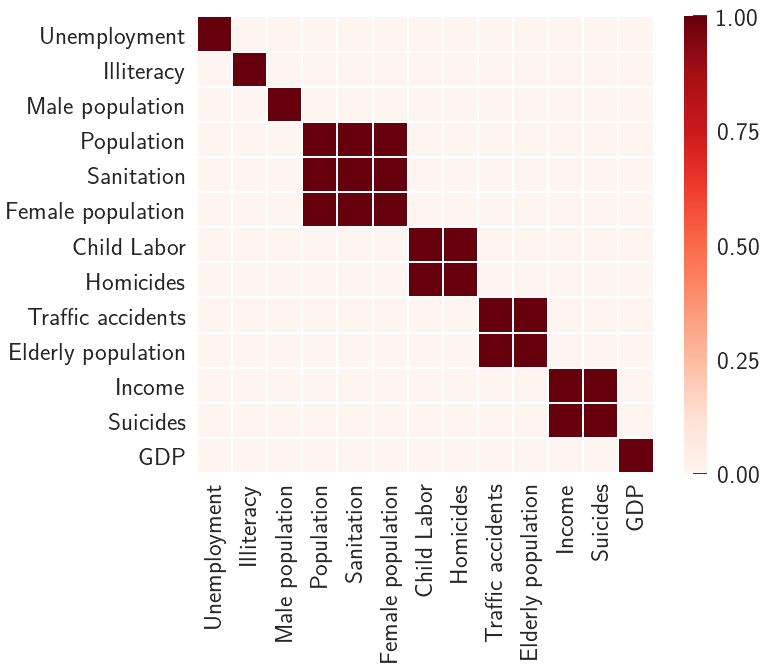

In [97]:
p=test2samples(np.array(importance_df))
p=pd.DataFrame(p,index=list(importance_df.columns),columns=list(importance_df.columns))

fig, ax = plt.subplots(figsize=stdfigsize(scale=1.2))
res=sns.heatmap(p,vmin=0,vmax=1.,linewidths=1,annot=False,cmap="Reds",square=True)
#sns.clustermap(p,vmin=0,vmax=1.,annot=False,cmap="Reds")

cbar = res.collections[0].colorbar
cbar.set_ticks([0,0.25, 0.5,0.75, 1])
cbar.set_ticklabels(["0.00","0.25", "0.50","0.75", "1.00"])
#ax.tick_params(labelsize=22)